This is one that came up recently on the [mailing list](https://www.mail-archive.com/rdkit-discuss@lists.sourceforge.net/msg09570.html) that I thought made for a good example to demonstrate how to write Python to do some more advanced structural searches with the RDKit.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import rdkit
print(rdkit.__version__)

2019.09.3


RDKit WARNING: [05:43:19] Enabling RDKit 2019.09.3 jupyter extensions


My paraphrasing of the problem: Alexis wanted to be able to do the equivalent of a substructure 
search that finds all aromatic rings that have both Cl and Br substituents. So he wanted to be able to match the first two of these, but not the second:

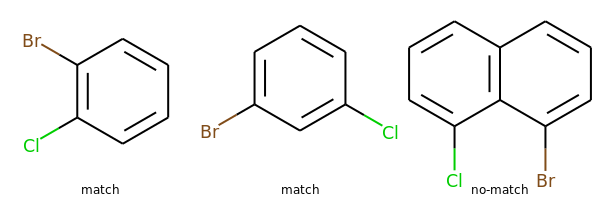

In [2]:
ms = [Chem.MolFromSmiles(x) for x in 'Clc1c(Br)cccc1 Clc1cc(Br)ccc1 Clc1cccc2c1c(Br)ccc2'.split()]
Draw.MolsToGridImage(ms,legends='match match no-match'.split())

It's really non-trivial to do this with SMARTS since it has no way to express that two atoms should be in the same ring without making the ring explicit in the SMARTS. I was able to come up with this SMARTS, which works, but is unwieldy (at best):

In [3]:
p = Chem.MolFromSmarts('Cl[c;$(c1(Cl)c(Br)cccc1),$(c1(Cl)cc(Br)ccc1),$(c1(Cl)ccc(Br)cc1)]')
print([m.HasSubstructMatch(p) for m in ms])

[True, True, False]


So that does what we want, but it only handles six rings where every atom is a C. That second part is easy enough to change in the SMARTS, but handling other ring sizes starts to make the SMARTS really long.

A more difficult problem is that, because we use recursive SMARTS, we can't get the atoms matching the query. The pattern I used above would only return the Cl atom and the C atom it's connected to. I'm not sure Alexis even wanted to do that, but by this point I was interested in the problem and decided to write some Python to solve the problem flexibly.

Here we go.

Before introducing the code and showing what it can do, a quick intro on the two pieces of functionality I'm going to be using from Python's `itertools` module. These are really useful.

Let's start with using itertools to flatten a sequence of sequences:

In [4]:
import itertools
seqs = [[1,2,3],['a','b'],[10,20]]
list(itertools.chain.from_iterable(seqs))

[1, 2, 3, 'a', 'b', 10, 20]

And to generate all the permutations of combinations of those sequences:

In [5]:
list(itertools.product(*seqs))

[(1, 'a', 10),
 (1, 'a', 20),
 (1, 'b', 10),
 (1, 'b', 20),
 (2, 'a', 10),
 (2, 'a', 20),
 (2, 'b', 10),
 (2, 'b', 20),
 (3, 'a', 10),
 (3, 'a', 20),
 (3, 'b', 10),
 (3, 'b', 20)]

Ok, that's the background, let's define the functions we'll use:

In [6]:
import itertools
def getAromaticRings(mol):
    """ generator returning all aromatic rings (=only aromatic bonds) in a molecule 
    
    Parameters
    ----------
    mol : Mol

    Yields
    ------
    set
        IDs of the atoms in an aromatic ring
    
    """
    ri = mol.GetRingInfo()
    for ring in ri.BondRings():
        ats = set()
        isArom = True
        for bi in ring:
            bnd = mol.GetBondWithIdx(bi)
            if not bnd.GetIsAromatic():
                isArom = False
                break
            ats.add(bnd.GetBeginAtomIdx())
            ats.add(bnd.GetEndAtomIdx())
        if isArom:
            yield ats

def getSharedRings(mol,queries,rings=None,excludeQueries=None):
    """ generator returning all rings that contain all the atoms defined in queries 
        the first atom matching each query should be in the ring

    Parameters
    ----------
    mol : Mol
    queries : sequence of Mols
    rings : list/tuple/set of list/tuple/sets, optional
        sequence of rings defined by sequences of atom ids
        If this isn't provided, all of the molecule's rings will be used
    excludeQueries : sequence of Mols, optional
        any ring containing an atom matching the first atom in any of these queries
        will be excluded

    Yields
    -------
    set
       containing atom IDs for a matching ring

    """
    if rings is None:
        rings = mol.GetRingInfo().AtomRings()
    alreadySeen = []
    rings = [set(x) for x in rings]
    matchSets = [[x[0] for x in mol.GetSubstructMatches(q)] for q in queries]
    if excludeQueries is not None:
        exclude = [[x[0] for x in mol.GetSubstructMatches(q)] for q in excludeQueries]
        # flatten the lists of matches into a set:
        exclude = set(itertools.chain.from_iterable(exclude))
    else:
        exclude = set()
    for combo in itertools.product(*matchSets):
        scombo = set(combo)
        if len(scombo) < len(combo):
            # degenerate:
            continue
        for ring in rings:
            if ring in alreadySeen:
                continue
            if scombo.issubset(ring) and exclude.isdisjoint(ring):
                alreadySeen.append(ring)
                yield ring

def drawMolWithRings(mol,rings):
    """ draws a molecule with a set of rings highlighted
    
    Parameters
    ----------
    mol : Mol
    rings : list/tuple/set of list/tuple/sets
        sequence of rings defined by sequences of atom IDs

    Returns
    -------
    Image

    """
    bondsToHighlight=[]
    for bnd in mol.GetBonds():
        keep = False
        ats = set([bnd.GetBeginAtomIdx(),bnd.GetEndAtomIdx()])
        for ring in rings:
            if ats.issubset(ring):
                keep = True
                break
        if keep:
            bondsToHighlight.append(bnd.GetIdx())
    highlightAtoms = list(itertools.chain.from_iterable(rings))

    tmol = Draw.PrepareMolForDrawing(mol)
    d2d = Draw.MolDraw2DCairo(300, 250)
    d2d.DrawMolecule(tmol, highlightAtoms=highlightAtoms, 
                     highlightBonds = bondsToHighlight)
    d2d.FinishDrawing()
    return Draw._drawerToImage(d2d)

This is the molecule we'll work with:

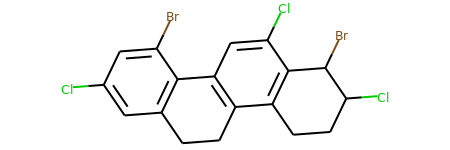

In [7]:
mol = Chem.MolFromSmiles('c1c(Cl)cc(Br)c2c1CCc3c2cc(Cl)c4c3CCC(Cl)C4Br')
mol

Show what the `getAromaticRings()` function returns here:

In [8]:
rings = list(getAromaticRings(mol))
rings

[{0, 1, 3, 4, 6, 7}, {10, 11, 12, 13, 15, 16}]

We can use `drawMolWithRings()` to highlight those atoms:

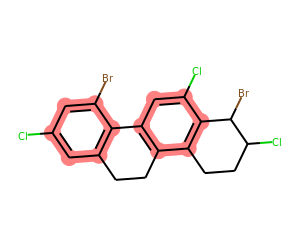

In [9]:
drawMolWithRings(mol,rings)

Now let's look at Alexis' question: find all the aromatic rings that have a Cl and a Br attached:

[{0, 1, 3, 4, 6, 7}]


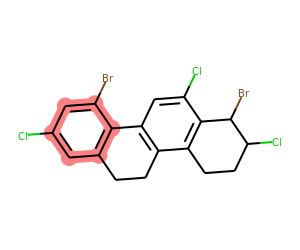

In [10]:
matches = list(getSharedRings(mol,[Chem.MolFromSmarts(sma) for sma in ('[a]-Cl','[a]-Br')],
                              rings=getAromaticRings(mol)))
print(matches)
drawMolWithRings(mol,matches)

What about aromatic rings that have both a Cl and an aliphatic C attached?

[{0, 1, 3, 4, 6, 7}, {16, 10, 11, 12, 13, 15}]


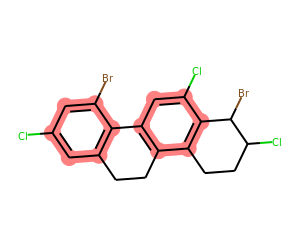

In [11]:
matches = list(getSharedRings(mol,[Chem.MolFromSmarts(sma) for sma in ('[a]-Cl','[a]-C')],
                             rings=getAromaticRings(mol)))
print(matches)
drawMolWithRings(mol,matches)

What about just finding any rings (not just aromatic) that have both Cl and Br connected?

Here we just drop the `rings` argument to `getSharedRings()`, it will use all of the molecule's rings:

[{0, 1, 3, 4, 6, 7}, {15, 16, 17, 18, 19, 21}]


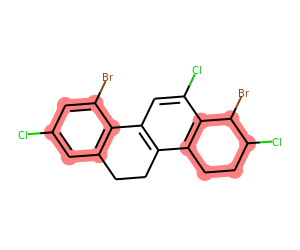

In [12]:
matches = list(getSharedRings(mol,[Chem.MolFromSmarts(sma) for sma in ('[*]-Cl','[*]-Br')]))
print(matches)
drawMolWithRings(mol,matches)

We can also find any rings that have a Cl, but *not* a Br:

[{10, 11, 12, 13, 15, 16}]


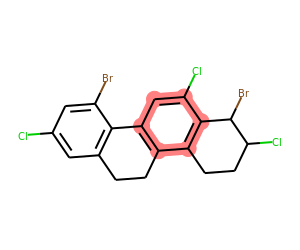

In [13]:
matches = list(getSharedRings(mol,[Chem.MolFromSmarts(sma) for sma in ('[*]-Cl',)],
                              excludeQueries=[Chem.MolFromSmarts(sma) for sma in ('[*]-Br',)]))
print(matches)
drawMolWithRings(mol,matches)

We aren't limited to just six membered rings, of course. Go back to the original query for aromatic rings with both Cl and Br attached:

[{1, 2, 3, 5, 14}, {6, 7, 8, 9, 11, 13}]


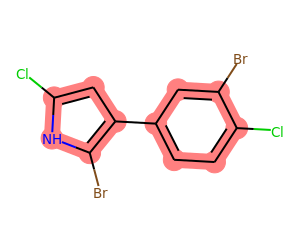

In [14]:
mol = Chem.MolFromSmiles('Clc1[nH]c(Br)c(c2ccc(Cl)c(Br)c2)c1')
matches = list(getSharedRings(mol,[Chem.MolFromSmarts(sma) for sma in ('[*]-Cl','[*]-Br')],
                              rings=getAromaticRings(mol)))
print(matches)
drawMolWithRings(mol,matches)

What about aromatic rings that have both Cl and Br attached, but that don't contain a heteroatom?

[{6, 7, 8, 9, 11, 13}]


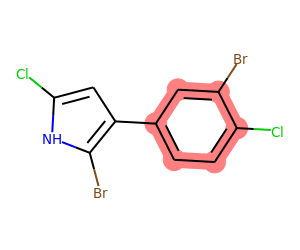

In [15]:
mol = Chem.MolFromSmiles('Clc1[nH]c(Br)c(c2ccc(Cl)c(Br)c2)c1')
matches = list(getSharedRings(mol,[Chem.MolFromSmarts(sma) for sma in ('[*]-Cl','[*]-Br')],
                              rings=getAromaticRings(mol),
                              excludeQueries=[Chem.MolFromSmarts(sma) for sma in ('[a;!#6]',)]))
print(matches)
drawMolWithRings(mol,matches)

Hopefully there's some useful stuff in here for you!